In [ ]:
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
!pip install segmentation-models
from random import randint
import tensorflow
import matplotlib.pyplot as plt
!pip install varname
from varname import nameof

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

# **Functions to calculate metrics**

In [ ]:
#number to round up decimal points by
DECIMAL_POINTS= 4

In [ ]:
#IOU FUNCTION
"""
from keras.metrics import MeanIoU
IOU_keras= MeanIoU(num_classes=3) 
IOU_keras.update_state(test_masks, test_pred)
print(IOU_keras.result().numpy())

values= np.array(IOU_keras.get_weights()).reshape(65536)
print(values)

class1_IoU = values[0]/(values[0] + values[0] + values[0] + values[0] + values[1]+ values[2]+ values[3])
class2_IoU = values[1]/(values[1] + values[1] + values[1] + values[1] + values[0]+ values[2]+ values[3])
class3_IoU = values[2]/(values[2] + values[2] + values[2] + values[2] + values[0]+ values[1]+ values[3])
class4_IoU = values[3]/(values[3] + values[3] + values[3] + values[3] + values[0]+ values[1]+ values[2])
print(class1_IoU, class2_IoU, class3_IoU, class4_IoU)

"""

def calculate_iou(test_pred, test_masks):
  IOU = tf.keras.metrics.IoU(num_classes=3, target_class_ids=[0])
  IOU.update_state(test_masks, test_pred)
  IOU_score= IOU.result().numpy()

  IOU_score= round(IOU_score, DECIMAL_POINTS)
  return IOU_score


In [ ]:
#F1 SCORE FUNCTION

def calculate_f1(test_pred, test_masks):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(test_masks, test_pred)
  tp_score= tp.result().numpy()

  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(test_masks, test_pred)
  fp_score= fp.result().numpy()

  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(test_masks, test_pred)
  fn_score= fn.result().numpy()

  f1_score= tp_score / (tp_score + (0.5 * (fp_score + fn_score)))
  f1_score= round(f1_score, DECIMAL_POINTS)
  return f1_score

  """
  precision = tf.keras.metrics.Precision()
  precision.update_state(test_masks, test_pred)
  precision_score= precision.result().numpy()

  recall = tf.keras.metrics.Recall()
  recall.update_state(test_masks, test_pred)
  recall_score= recall.result().numpy()

  f1_score= (2 * (precision_score * recall_score)) / (precision_score + recall_score)
  return f1_score

  """

In [ ]:
#SENSITIVITY FUNCTION

def calculate_sensitivity(test_pred, test_masks):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(test_masks, test_pred)
  tp_score= tp.result().numpy()

  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(test_masks, test_pred)
  fn_score= fn.result().numpy()

  sensitivity= tp_score/(tp_score+fn_score)
  sensitivity= round(sensitivity, DECIMAL_POINTS)
  return sensitivity

In [ ]:
#SPECIFICITY FUNCTION

def calculate_specificity(test_pred, test_masks):
  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(test_masks, test_pred)
  tn_score= tn.result().numpy()

  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(test_masks, test_pred)
  fp_score= fp.result().numpy()

  specificity= tn_score/(tn_score+fp_score)
  specificity= round(specificity, DECIMAL_POINTS)
  return specificity

In [ ]:
#ACCURACY FUNCTION

def calculate_accuracy(test_pred, test_masks):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(test_masks, test_pred)
  tp_score= tp.result().numpy()

  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(test_masks, test_pred)
  tn_score= tn.result().numpy()

  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(test_masks, test_pred)
  fp_score= fp.result().numpy()

  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(test_masks, test_pred)
  fn_score= fn.result().numpy()

  accuracy_score=  (tp_score + tn_score)/ (tp_score + tn_score + fp_score + fn_score)
  accuracy_score= round(accuracy_score, DECIMAL_POINTS)

  return accuracy_score

In [ ]:
#PRECISION FUNCTION

def calculate_precision(test_pred, test_masks):
  precision = tf.keras.metrics.Precision()
  precision.update_state(test_masks, test_pred)
  precision_score= precision.result().numpy()

  precision_score= round(precision_score, DECIMAL_POINTS)
  return precision_score

In [ ]:
#RECALL FUNCTION

def calculate_recall(test_pred, test_masks):
  recall = tf.keras.metrics.Recall()
  recall.update_state(test_masks, test_pred)
  recall_score= recall.result().numpy()

  recall_score= round(recall_score, DECIMAL_POINTS)
  return recall_score

# **EVALUATION (METRICS) FOR EACH MODEL**

In [ ]:
def convert_to_dim3(test_preds):
  test_preds= np.expand_dims(test_preds, axis=3)

  n_classes=3
  import tensorflow as tf
  from tensorflow.keras.utils import to_categorical
  test_pred_con = to_categorical(test_preds, num_classes=n_classes)
  test_pred_con = test_pred_con.reshape((test_preds.shape[0], test_preds.shape[1], test_preds.shape[2], n_classes))

  return test_pred_con

In [ ]:
def load_images(model, BACKBONE):
  test_images= pickle.load(open(DATA_PATH+"test_images.pkl", "rb"))
  test_masks= pickle.load(open(DATA_PATH+"test_masks.pkl", "rb"))

  preprocess_input= sm.get_preprocessing(BACKBONE)
  test_images= preprocess_input(test_images)
  test_preds= model.predict(test_images)
  test_preds=  np.argmax(test_preds, axis=3)


  test_preds= convert_to_dim3(test_preds)
  test_masks= convert_to_dim3(test_masks)
  return test_images, test_preds, test_masks

In [ ]:
from tensorflow import keras
resnet50 = keras.models.load_model(DATA_PATH+"resnet50", compile=False)
vgg16 = keras.models.load_model(DATA_PATH+"vgg16", compile=False)
densenet121 = keras.models.load_model(DATA_PATH+"densenet121", compile=False)
inceptionv3 = keras.models.load_model(DATA_PATH+"inceptionv3", compile=False)
inceptionresnetv2 = keras.models.load_model(DATA_PATH+"inceptionresnetv2", compile=False)

In [ ]:
def ensemble_models(models, backbones, weights):
  preds= []
  for i in range(len(models)):
    test_images= pickle.load(open(DATA_PATH+"test_images.pkl", "rb"))
    test_images_for_vis= test_images.copy()
    test_masks= pickle.load(open(DATA_PATH+"test_masks.pkl", "rb"))
    preprocess_input= sm.get_preprocessing(backbones[i])
    test_images= preprocess_input(test_images)
    test_preds= models[i].predict(test_images)
    preds.append(test_preds)

  preds= np.array(preds)
  weighted_preds= np.tensordot(preds, weights, axes= ((0), (0)))
  weighted_ensemble_prediction= np.argmax(weighted_preds, axis=3)
  vis= [test_images_for_vis,  test_masks, weighted_ensemble_prediction] 

  final_preds= convert_to_dim3(weighted_ensemble_prediction)
  test_masks= convert_to_dim3(test_masks)

  return test_images, final_preds, test_masks, vis

def ensemble_visualizations(vis, n=0):

  plt.subplot(1,3,1)
  plt.imshow(vis[0][n])
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(vis[1][n], cmap= "gray")
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(vis[2][n], cmap= "gray")
  plt.axis('off')


Intersection over union score is 0.8725
F1 score is 0.8638
Sensitivity score is 0.8638
Specificity score is 0.9319


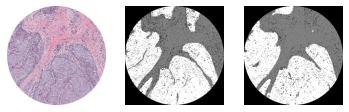

In [ ]:
models= [inceptionresnetv2, densenet121]
backbones= ["inceptionresnetv2", "densenet121"]
weights= [0.5, 0.5]
test_images, final_preds, test_masks, vis= ensemble_models(models, backbones, weights)

print("Intersection over union score is", calculate_iou(final_preds, test_masks))
print("F1 score is", calculate_f1(final_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(final_preds, test_masks))
print("Specificity score is", calculate_specificity(final_preds, test_masks))

ensemble_visualizations(vis, 0)

In [ ]:
combine= [resnet50, "resnet50"], [vgg16, "vgg16"], [densenet121, "densenet121"], [inceptionv3, "inceptionv3"], [inceptionresnetv2, "inceptionresnetv2"]

#function to check the combination of all two models
def combine_two_models_iter(combine= combine):
  weights= [0.5, 0.5]
  scores= []
  for i in range(len(combine)):
    for j in range(len(combine)):
      if(j == i):
        continue
      else:
        models= [combine[i][0], combine[j][0]]
        backbones= [combine[i][1], combine[j][1]]
        test_images, final_preds, test_masks, vis= ensemble_models(models, backbones, weights)
          
        a, b, c, d, e= calculate_accuracy(final_preds, test_masks), calculate_iou(final_preds, test_masks), calculate_f1(final_preds, test_masks), calculate_sensitivity(final_preds, test_masks), calculate_specificity(final_preds, test_masks)
        t= "ENSEMBLE of " + combine[i][1] + " + " + combine[j][1] 
        #print(t)
        #print("Accuracy score is", a)
        #print("Intersection over union score is", b)
        #print("F1 score is", c)
        #print("Sensitivity score is", d)
        #print("Specificity score is", e)
        #print("\n\n")
        score= [a,b,c,d,e,t]
        scores.append(score)
  """
  temp= 0.000
  fin= []
  for i in range(len(scores)):
    if(scores[i][0]>temp):
      fin= scores[i]
  #print(fin[-1], "has the best IOU score with ", fin[0])
  """

  return scores

#function to check for all combinations of three models
def combine_three_models_iter(combine= combine):
  sp= 100/3
  weights= [sp, sp, sp]
  scores= []
  for i in range(len(combine)):
    for j in range(len(combine)):
      if(j == i):
        continue
      for k in range(len(combine)):
        if(i == k or j == k):
          continue
        else:
          models= [combine[i][0], combine[j][0], combine[k][0]]
          backbones= [combine[i][1], combine[j][1], combine[k][1]]
          test_images, final_preds, test_masks, vis= ensemble_models(models, backbones, weights)

          a, b, c, d, e= calculate_accuracy(final_preds, test_masks), calculate_iou(final_preds, test_masks), calculate_f1(final_preds, test_masks), calculate_sensitivity(final_preds, test_masks), calculate_specificity(final_preds, test_masks)
          t= "ENSEMBLE of " + combine[i][1] + " + " + combine[j][1] + " + " + combine[k][1]
          #print(t)
          #print("Accuracy score is", a)
          #print("Intersection over union score is", b)
          #print("F1 score is", c)
          #print("Sensitivity score is", d)
          #print("Specificity score is", e)
          #print("\n\n")
          score= [a,b,c,d,e,t]
          scores.append(score)

  """
  temp= 0.000
  fin= []
  for i in range(len(scores)):
    if(scores[i][0]>temp):
      fin= scores[i]
  #print(fin[-1], "has the best IOU score with ", fin[0])
  """
  return scores


#functions to check for all combinations of four models 
def combine_four_models_iter(combine= combine):
  sp= 100/4
  weights= [sp, sp, sp, sp]
  scores= []
  for i in range(len(combine)):
    for j in range(len(combine)):
      if(j == i):
        continue
      for k in range(len(combine)):
        if(i == k or j == k):
          continue
        for l in range(len(combine)):
          if(i == l or j == l or k == l):
            continue
          else:
            models= [combine[i][0], combine[j][0], combine[k][0], combine[l][0]]
            backbones= [combine[i][1], combine[j][1], combine[k][1], combine[l][1]]
            test_images, final_preds, test_masks, vis= ensemble_models(models, backbones, weights)
            a, b, c, d, e= calculate_accuracy(final_preds, test_masks), calculate_iou(final_preds, test_masks), calculate_f1(final_preds, test_masks), calculate_sensitivity(final_preds, test_masks), calculate_specificity(final_preds, test_masks)
            t= "ENSEMBLE of " + combine[i][1] + " + " + combine[j][1] + " + " + combine[k][1] + " + " + combine[l][1]
            #print(t)
            #print("Accuracy score is", a)
            #print("Intersection over union score is", b)
            #print("F1 score is", c)
            #print("Sensitivity score is", d)
            #print("Specificity score is", e)
            #print("\n\n")
            score= [a,b,c,d,e,t]
            scores.append(score)

  """
  temp= 0.000
  fin= []
  for i in range(len(scores)):
    if(scores[i][0]>temp):
      fin= scores[i]
  #print(fin)
  #print(fin[-1], "has the best IOU score with ", fin[0])
  """

  return scores    


#function to filter out repetitive models
def filter(scores):
  all= []
  final= []
  for i in scores:
    if(sorted(list(i[-1])) not in all):
      all.append(sorted(list(i[-1])))
      final.append(i)
      #print(sorted(list(i[-1])))
    else:
      continue
  return final



def get_positions(scores):
  acc= []
  iou= []
  f1= []
  sens= []
  spec= []

  nn= 0
  for i in scores:
    s= "" + str(i[0]) + " " + i[-1]
    acc.append(s)
    s= "" + str(i[1]) + " " + i[-1]
    iou.append(s)
    s= "" + str(i[2]) + " " + i[-1]
    f1.append(s)
    s= "" + str(i[3]) + " " + i[-1]
    sens.append(s)
    s= "" + str(i[4]) + " " + i[-1]
    spec.append(s)
    nn= nn+1

    
  acc.sort(reverse=True)
  iou.sort(reverse= True)
  f1.sort(reverse= True)
  sens.sort(reverse= True)
  spec.sort(reverse= True)

  acc_out, iou_out, f1_out, sens_out, spec_out= "", "", "", "", ""
  for j in acc:
    acc_out+= j + "\n\n"
  for j in iou:
    iou_out+= j + "\n\n"
  for j in f1:
    f1_out+= j + "\n\n"
  for j in sens:
    sens_out+= j + "\n\n"
  for j in spec:
    spec_out+= j + "\n\n"

  return [acc_out, iou_out, f1_out, sens_out, spec_out]


def get_list_best_models(scores):
  new_score= filter(scores)
  sorted_scores= get_positions(new_score)
  return sorted_scores


def show_output(sorted_scores):
  print("\tACCURACY SCORE")
  print(sorted_scores[0])
  
  print("\tIOU SCORE")
  print(sorted_scores[1])

  print("\tF1 SCORE")
  print(sorted_scores[2])

  print("\tSENSITIVITY SCORE")
  print(sorted_scores[3])

  print("\tSPECIFICITY SCORE")
  print(sorted_scores[4])

 

In [ ]:
two_scores= get_list_best_models(combine_two_models_iter())
three_scores= get_list_best_models(combine_three_models_iter())
four_scores= get_list_best_models(combine_four_models_iter())

In [ ]:
print("\n\nCOMBINATIONS OF 2 MODELS (results)\n")
show_output(two_scores)



COMBINATIONS OF 2 MODELS (results)

	ACCURACY SCORE
0.9092 ENSEMBLE of resnet50 + inceptionresnetv2

0.9092 ENSEMBLE of densenet121 + inceptionresnetv2

0.9067 ENSEMBLE of resnet50 + densenet121

0.9064 ENSEMBLE of inceptionv3 + inceptionresnetv2

0.906 ENSEMBLE of vgg16 + inceptionresnetv2

0.9043 ENSEMBLE of vgg16 + densenet121

0.9039 ENSEMBLE of densenet121 + inceptionv3

0.9028 ENSEMBLE of resnet50 + inceptionv3

0.8991 ENSEMBLE of vgg16 + inceptionv3

0.898 ENSEMBLE of resnet50 + vgg16


	IOU SCORE
0.8725 ENSEMBLE of resnet50 + inceptionresnetv2

0.8725 ENSEMBLE of densenet121 + inceptionresnetv2

0.8693 ENSEMBLE of resnet50 + densenet121

0.8688 ENSEMBLE of inceptionv3 + inceptionresnetv2

0.8683 ENSEMBLE of vgg16 + inceptionresnetv2

0.8661 ENSEMBLE of vgg16 + densenet121

0.8655 ENSEMBLE of densenet121 + inceptionv3

0.8641 ENSEMBLE of resnet50 + inceptionv3

0.8593 ENSEMBLE of vgg16 + inceptionv3

0.8579 ENSEMBLE of resnet50 + vgg16


	F1 SCORE
0.8638 ENSEMBLE of resnet50 +

In [ ]:
print("\n\nCOMBINATIONS OF 3 MODELS (results)\n")
show_output(three_scores)



COMBINATIONS OF 3 MODELS (results)

	ACCURACY SCORE
0.9118 ENSEMBLE of resnet50 + inceptionv3 + inceptionresnetv2

0.9118 ENSEMBLE of resnet50 + densenet121 + inceptionresnetv2

0.9102 ENSEMBLE of densenet121 + inceptionv3 + inceptionresnetv2

0.909 ENSEMBLE of vgg16 + inceptionv3 + inceptionresnetv2

0.909 ENSEMBLE of resnet50 + densenet121 + inceptionv3

0.9088 ENSEMBLE of vgg16 + densenet121 + inceptionresnetv2

0.9084 ENSEMBLE of vgg16 + densenet121 + inceptionv3

0.9072 ENSEMBLE of resnet50 + vgg16 + inceptionv3

0.9072 ENSEMBLE of resnet50 + vgg16 + inceptionresnetv2

0.9071 ENSEMBLE of resnet50 + vgg16 + densenet121


	IOU SCORE
0.876 ENSEMBLE of resnet50 + densenet121 + inceptionresnetv2

0.8759 ENSEMBLE of resnet50 + inceptionv3 + inceptionresnetv2

0.8739 ENSEMBLE of densenet121 + inceptionv3 + inceptionresnetv2

0.8722 ENSEMBLE of vgg16 + inceptionv3 + inceptionresnetv2

0.8722 ENSEMBLE of resnet50 + densenet121 + inceptionv3

0.872 ENSEMBLE of vgg16 + densenet121 + incept

In [ ]:
print("\n\nCOMBINATIONS OF 4 MODELS (results)\n")
show_output(four_scores)



COMBINATIONS OF 4 MODELS (results)

	ACCURACY SCORE
0.9127 ENSEMBLE of resnet50 + vgg16 + inceptionv3 + inceptionresnetv2

0.9126 ENSEMBLE of resnet50 + vgg16 + densenet121 + inceptionresnetv2

0.9124 ENSEMBLE of resnet50 + densenet121 + inceptionv3 + inceptionresnetv2

0.9112 ENSEMBLE of vgg16 + densenet121 + inceptionv3 + inceptionresnetv2

0.9106 ENSEMBLE of resnet50 + vgg16 + densenet121 + inceptionv3


	IOU SCORE
0.8771 ENSEMBLE of resnet50 + vgg16 + inceptionv3 + inceptionresnetv2

0.8769 ENSEMBLE of resnet50 + vgg16 + densenet121 + inceptionresnetv2

0.8767 ENSEMBLE of resnet50 + densenet121 + inceptionv3 + inceptionresnetv2

0.8751 ENSEMBLE of vgg16 + densenet121 + inceptionv3 + inceptionresnetv2

0.8743 ENSEMBLE of resnet50 + vgg16 + densenet121 + inceptionv3


	F1 SCORE
0.8691 ENSEMBLE of resnet50 + vgg16 + inceptionv3 + inceptionresnetv2

0.8689 ENSEMBLE of resnet50 + vgg16 + densenet121 + inceptionresnetv2

0.8686 ENSEMBLE of resnet50 + densenet121 + inceptionv3 + incepti